# MNIST Convolutional Autoencoder

Below is a step-by-step demonstration of how to train a convolutional autoencoder for MNIST digit generation using PyTorch. This includes defining the model, training it on the MNIST dataset, and using the trained decoder to generate new digits.

## Import Required Libraries


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from torchinfo import summary
from utils import train_model # our home-brewed training wrapper

sns.set_theme()

## Custom Dataset

With an autoencoder the target for the output is the input data so we can either customize our training loop or modify the dataset so that it returns '(data,data)' instead of '(data,loader)'.  We'll opt for the second approach so that we can continue to use `train_network` or `train_model` to manage the training.

In [2]:
class AutoEncoderDataset(Dataset):
    def __init__(self, orig_dataset):
        """
        Takes a dataset with (data,label) pairs and converts it to (data,data) pairs.
        This makes it easy to re-use other code.
        
        Args:
            orig_dataset (Dataset): The original PyTorch dataset.
        """
        self.orig_dataset = orig_dataset

    def __len__(self):
        return len(self.orig_dataset)

    def __getitem__(self, idx):
        data, _ = self.orig_dataset[idx]
        # Return data as both input and target
        return data, data

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

orig_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_dataset = AutoEncoderDataset(orig_train_dataset)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

orig_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_dataset = AutoEncoderDataset(orig_test_dataset)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

### 2. Convolutional Autoencoder

To build a convolutional autoencoder for images, we start with an encoder similar to the CNN we used to classify images.  It contains multiple convolutional layers with batch normalizations and `LeakyReLU` activations, followed by a typical classifier head containing a hidden layer, an output layer, and activations.

The decoder starts with an "inverse" classifier head that increases the dimensions of the encoded vectors and "transposed" convolutional layers `ConvTranspose2D`:

### Key Parameters:

- **in_channels**: The number of channels in the input image.
- **out_channels**: The number of channels produced by the convolution.
- **kernel_size**: The size of the kernel/filter. It defines the dimension of the convolution window.
- **stride**: The number of pixels to skip as the filter is slid over the input image. A larger stride results in a larger output spatial dimension.
- **padding**: The amount of padding added to the input. It can affect the output size.
- **output_padding**: Additional size added to one side of the output shape. This is used to control the exact size of the output.
- **dilation**: The spacing between the kernel elements. It influences the receptive field.

### How It Works:

Unlike standard convolution (`Conv2d`), which reduces the spatial dimensions of the input, `ConvTranspose2d` works by inserting zeros between the input tensor elements (a process known as *dilation* or *up-sampling*) before applying the convolution operation. This zero-insertion step is often misconceived as the only step, but the process also involves a convolution with the kernel over the dilated input.

Here's a simplified view of the steps involved:

1. **Zero-padding**: First, the input is padded with zeros on the border if padding is specified.
2. **Zero-insertion (Dilation)**: Zeros are inserted between input elements if the stride exceeds 1. This effectively increases the spatial dimensions of the input.
3. **Convolution**: Then, a standard convolution operation is applied to the dilated input with the specified kernel, stride, and additional parameters.

The decoder uses multiple transposed convolution operators to "undo" the convolution operations used in the encoder.  See the code below:

In [32]:
def getConvLayer(in_chan, out_chan, kernel_size = 3, stride=2, padding = 1, leak_rate = 0.1):
    layers = nn.Sequential(
        nn.Conv2d(in_chan, out_chan, kernel_size, stride=stride, padding = padding),
        nn.BatchNorm2d(out_chan),
        nn.LeakyReLU(leak_rate, inplace=True)
    )
    return layers

def getConvTransposeLayer(in_chan, out_chan, kernel_size = 3, stride=2, padding = 1, out_padding=1, leak_rate = 0.1):
    layers = nn.Sequential(
        nn.ConvTranspose2d(in_chan, out_chan, kernel_size, stride=stride, padding = padding, output_padding=out_padding),
        nn.BatchNorm2d(out_chan),
        nn.LeakyReLU(leak_rate, inplace=True)
    )
    return layers

def getLinear(inputs, hidden, outputs, leak_rate = 0.1):
    layers = nn.Sequential(
        nn.Linear(inputs, hidden),
        nn.LeakyReLU(leak_rate, inplace=True),
        nn.Linear(hidden, outputs),
        nn.LeakyReLU(leak_rate, inplace=True)
    )
    return layers
        

class ConvAutoencoder(nn.Module):
    def __init__(self, encoded_size=10):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            getConvLayer(1,32), # 1x28x28 -> 8x14x14
            getConvLayer(32,64), # 8x14x14 -> 16x7x7
            getConvLayer(64,128,padding=0), # 16x7x7 -> 32x3x3
            nn.Flatten(), #32x3x3 -> one dimesional 32*3*3
            getLinear(128*3*3, 128, encoded_size) # 32*3*3 -> 128 -> encoded_size
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            getLinear(encoded_size, 128, 128*3*3),
            nn.Unflatten(dim=1, unflattened_size=(128,3,3)),
            getConvTransposeLayer(128,64,padding=0,out_padding=0),
            getConvTransposeLayer(64,32),
            getConvTransposeLayer(32,1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


Let's use `summary` from `torchinfo` to see how the shape of a batch of images changes as it passes through our autoencoder:

In [33]:
encoded_length = 4
convauto_model = ConvAutoencoder(encoded_size=encoded_length)

summary_str = summary(convauto_model, input_size = (64,1,28,28), col_names = ["input_size","output_size","num_params"])
print(summary_str)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ConvAutoencoder                          [64, 1, 28, 28]           [64, 1, 28, 28]           --
├─Sequential: 1-1                        [64, 1, 28, 28]           [64, 4]                   --
│    └─Sequential: 2-1                   [64, 1, 28, 28]           [64, 32, 14, 14]          --
│    │    └─Conv2d: 3-1                  [64, 1, 28, 28]           [64, 32, 14, 14]          320
│    │    └─BatchNorm2d: 3-2             [64, 32, 14, 14]          [64, 32, 14, 14]          64
│    │    └─LeakyReLU: 3-3               [64, 32, 14, 14]          [64, 32, 14, 14]          --
│    └─Sequential: 2-2                   [64, 32, 14, 14]          [64, 64, 7, 7]            --
│    │    └─Conv2d: 3-4                  [64, 32, 14, 14]          [64, 64, 7, 7]            18,496
│    │    └─BatchNorm2d: 3-5             [64, 64, 7, 7]            [64, 64, 7, 7]            128
│    │    └─LeakyReLU: 3-6   

## Train the Autoencoder

Initialize the model, define the loss function and optimizer, and start the training loop.  Thirty epochs is likely overkill!

In [34]:
encoded_length = 4
convauto_model = ConvAutoencoder(encoded_size=encoded_length)
loss_func = nn.MSELoss()

convauto_df = train_model(convauto_model, loss_func, epochs=30, train_loader=train_loader)

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 30/30, Training 100.00% complete lr = 1.000e-03
 Epoch  train_loss      Time    LR
    26    0.098365 21.988139 0.001
    27    0.097878 22.025899 0.001
    28    0.097668 21.454607 0.001
    29    0.097297 21.959958 0.001
    30    0.096919 22.954045 0.001


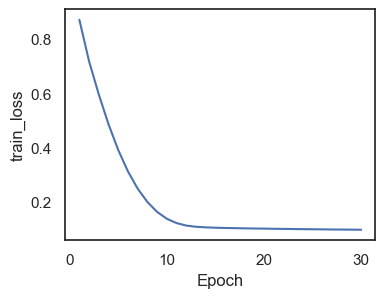

In [35]:
fig,ax = plt.subplots(figsize=(4,3))
sns.set_theme(style='darkgrid')
sns.lineplot(x='Epoch', y='train_loss', data=convauto_df, ax=ax);

## Visualizing the encodings

We'll use t-SNE to visualize the encodings in two dimensional space.  Here's a snippet from a Quora page describing t-SNE:

"t-SNE, which stands for t-distributed stochastic neighbor embedding, is a machine learning algorithm used for visualizing high-dimensional data in a lower-dimensional space, typically 2D or 3D. It works by measuring the similarity between data points in the high-dimensional space and then representing these similarities as distances in the lower-dimensional space. By doing so, t-SNE aims to preserve the local structure of the data, meaning that nearby points in the high-dimensional space remain close to each other in the lower-dimensional space. This helps to reveal patterns and clusters in the data that may not be immediately apparent in the original high-dimensional space."

To do this, we'll use the test dataset with its original labels 0 through 9.  First we'll build a function to collect all of the encodings for our dataset:

In [36]:
def get_encodings_and_labels(encoder, dataset_to_encode):
    """
    encoder: the PyTorch network that takes in a dataset and convers it to a new dimension
    dataset_to_encode: a PyTorch `Dataset` object that we want to convert. 

    Returns a tuple (encodings, labels) where `enodings` is the encoded version of the dataset, 
    and `labels` are the original labels provided by the `dataset_to_encode`. 
    The outputs are moved to the cpu.
    """
    encodings = []
    labels = []

    encoder = encoder.eval()

    with torch.no_grad():
        for x, y in  DataLoader(dataset_to_encode, batch_size=128):
            z = encoder(x.cpu())
            encodings.append( z ) #store the encoded version & label
            labels.append( y )

    encodings = torch.cat(encodings).cpu()
    labels = torch.cat(labels).cpu()
    
    return encodings, labels

encodings, labels = get_encodings_and_labels(convauto_model.encoder, orig_test_dataset)

Now we'll convert the tensors to numpy arrays and use t-SNE to "project" onto two dimensions.

In [37]:
# initialize t-SNE
tsne = TSNE(n_components=2, random_state=42)

# do the dimensionality reduction
projections_tsne = tsne.fit_transform(encodings.numpy())

Finally, let's make a scatterplot:

<Axes: >

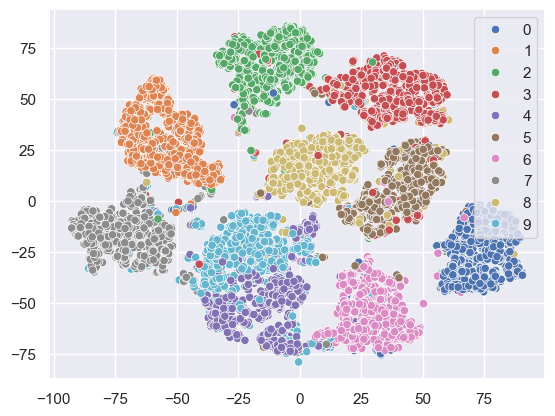

In [38]:
sns.scatterplot(x=projections_tsne[:,0], y=projections_tsne[:,1], 
                hue=[str(l) for l in labels.numpy()], 
                hue_order=[str(i) for i in range(10)], legend="full")

### Using PCA for visualization

In [39]:
# Initialize PCA, specifying the number of components to reduce to
pca = PCA(n_components=2)

# Fit PCA on the dataset and transform the data
projections_pca = pca.fit_transform(encodings.numpy())

<Axes: >

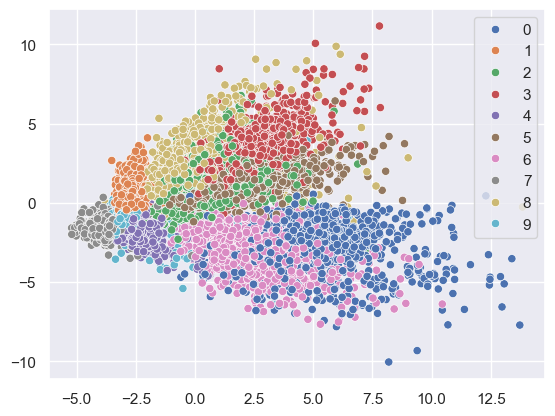

In [40]:
sns.scatterplot(x=projections_pca[:,0], y=projections_pca[:,1], 
                hue=[str(l) for l in labels.numpy()], 
                hue_order=[str(i) for i in range(10)], legend="full")

The textbook builds a higher fidelity network using bigger layer then adds dropout to make it more robust.

In [41]:
convauto_model(orig_test_dataset[0][0].unsqueeze(0)).shape

torch.Size([1, 1, 28, 28])

## Image Compression

Here we've distilled a small image from 784 numbers to 4 numbers.  This is a form of image compression.  Let's see well the compression works on the unseen test data.

In [42]:
def showEncodeDecode(encode_decode, x):
    """
    encode_decode: the PyTorch Module that does the encoding and decoding steps at once
    x: the input to plot as is, and after encoding & decoding it
    
    THIS version tweaked a bit from book for the convolutional model and because the output 
    needs to be denormalized
    """
    encode_decode = encode_decode.eval().cpu()
    with torch.no_grad():
        x_recon = encode_decode(x.unsqueeze(0).cpu())
    x_recon = (x_recon + 1)/2
    x_recon = np.clip(x_recon,0,1)
    # plot side-by-side
    f, axs = plt.subplots(1,2)
    axs[0].imshow(x.numpy()[0,:],cmap='gray')
    axs[1].imshow(x_recon.numpy()[0,0,:],cmap='gray')

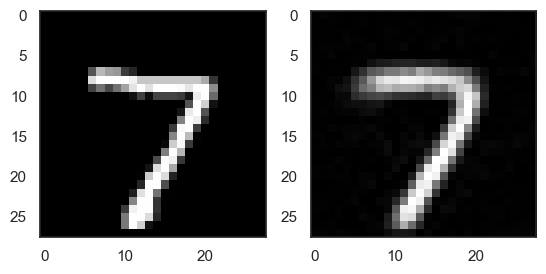

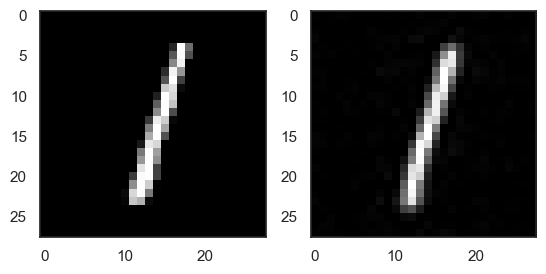

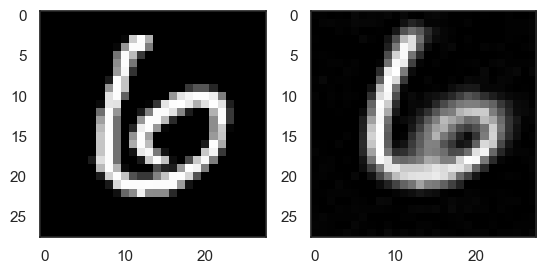

In [43]:
sns.set_theme(style="white")
showEncodeDecode(convauto_model, orig_test_dataset[0][0])
showEncodeDecode(convauto_model, orig_test_dataset[2][0])
showEncodeDecode(convauto_model, orig_test_dataset[11][0])

Instead of storing all of the 28*28 = 784 numbers for each digit, we could store the 4 numbers in the encoding and then use the decoder to reconstruct the digits.  The above pictures show that we should try to improve the autoencoder before using it for image compression.  Things to try:

* increase the encoder dimension
* increase the depth of the networks
* play with the sequence of layer sizes
* try a different loss function such as binary cross entropy (MSE doesn't necessarily line up with visual perception)

Do some internet research to explore the various loss functions that autoencoders can use for image compression and reconstruction.

## Denoising

For a noisy image, compressing it and reconstructing it with an autoencoder can remove the noise.  I'll show an example below, but the textbook goes more in-depth on this topic.

In [44]:
normal = torch.distributions.Normal(0, 1) #mean =0, std = 0.5

def addNoise(x, device='cpu'): 
    """
    We will use this helper function to add noise to some data. 
    x: the data we want to add noise to
    device: the CPU or GPU that the input is located on. 
    """
    return x + normal.sample(sample_shape=torch.Size(x.shape)).to(device) #$\boldsymbol{x} + s$

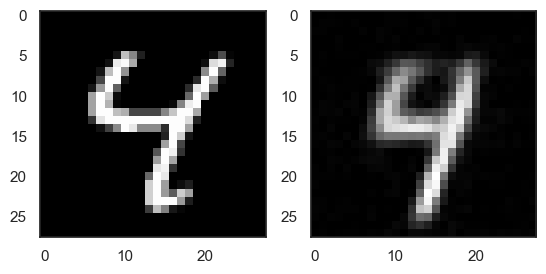

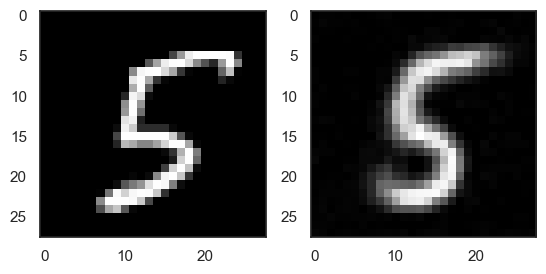

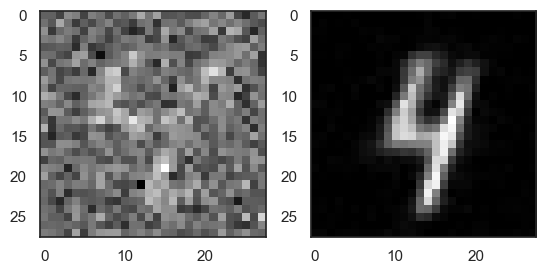

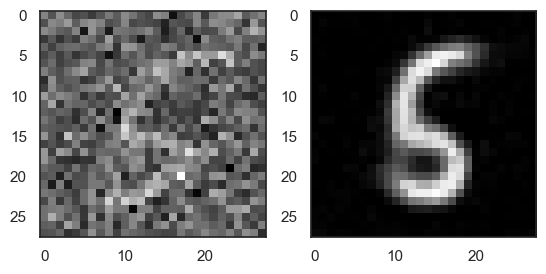

In [49]:
showEncodeDecode(convauto_model, orig_test_dataset[6][0])
showEncodeDecode(convauto_model, orig_test_dataset[23][0])
showEncodeDecode(convauto_model, addNoise(orig_test_dataset[6][0]))
showEncodeDecode(convauto_model, addNoise(orig_test_dataset[23][0]))

The textbook builds a higher fidelity network using bigger layer then adds dropout to make it more robust.

## Generating new digits

After training, you can use the decoder part of the autoencoder to generate new digits. 

To do this well, we want to generate a random encoded vector with the same mean and standard deviation as the encoded vector distribution in our dataset:

In [46]:
def calculate_output_statistics(model, loader):
    """
    Calculates the mean and standard deviation of the model's outputs
    for the given DataLoader.

    Parameters:
    - model: The PyTorch model to evaluate.
    - loader: DataLoader containing the dataset to evaluate the model on.

    Returns:
    - mean: The mean of the model's outputs.
    - std: The standard deviation of the model's outputs.
    """
    model.eval()  # Set the model to evaluation mode

    sums = 0
    squared_sums = 0
    n_samples = 0

    with torch.no_grad():  # No need to compute gradients
        for inputs, _ in loader:
            outputs = model(inputs)
            # Ensure outputs are 1D and on the same device as sums and squared_sums
            outputs = outputs.squeeze()  # Adjust based on your model's output shape

            sums += outputs.sum(dim=0)
            squared_sums += (outputs ** 2).sum(dim=0)
            n_samples += outputs.size(0)  # Increment total number of samples

    # Compute mean
    mean = sums / n_samples

    # Compute standard deviation
    std = torch.sqrt((squared_sums / n_samples) - (mean ** 2))

    return mean, std

mean, std = calculate_output_statistics(convauto_model.encoder, train_loader)
print("Mean:", mean)
print("Standard Deviation:", std)

Mean: tensor([1.7637, 0.8876, 0.7790, 2.9100])
Standard Deviation: tensor([2.3286, 2.0688, 2.5688, 2.2256])


torch.Size([128, 4])
(335, 335, 3)


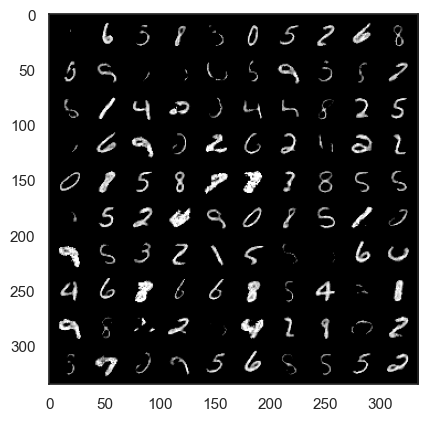

In [47]:
# Adjust the batch_size to the number of digits you'd like to generate
batch_size = 128 

# Generate random latent vectors with the correct shape and statistics
latent_vectors = torch.randn(batch_size,encoded_length)*std + mean
print(latent_vectors.shape)

# Use the decoder to generate images
with torch.no_grad():
    generated_images = convauto_model.decoder(latent_vectors)

# make a grid of images, we're only displaying the first 100
grid_of_digits = make_grid(generated_images[:100],10,5)

# convert to numpy image
grid_of_digits = np.transpose(grid_of_digits.cpu().numpy(), (1,2,0))
grid_of_digits = np.clip( grid_of_digits, 0, 1) # clip extreme values
print(grid_of_digits.shape)

sns.set_theme(style='white')
plt.imshow(grid_of_digits, cmap='gray')  # Ensure to move tensors to CPU if you're on a GPU
plt.show()

This code provides a basic framework. You might need to adjust the architecture, training duration, or other parameters to improve the generated images' quality. The generation process involves sampling from the latent space, which might not directly correspond to digits seen during training but should produce digit-like images.